### Life Expectancy EDA
- Kaggle 'Life Expectancy (WHO)'
    - https://www.kaggle.com/kumarajarshi/life-expectancy-who

In [96]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import preprocessing
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from PIL import Image as pil
import statsmodels.api as sm
import seaborn as sns

pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

In [146]:
PATH = '../datas/'
original = pd.read_csv(PATH + 'life_expectancy_data_fillna.csv')
original.columns = [cols.upper() for cols in original.columns.tolist()]

In [147]:
def add_feature(original, filename=None):
    path = "../datas/worldbank_"
    original.columns = [cols.upper() for cols in original.columns.tolist()]
    
    if not filename == None:
        df = pd.read_csv(f"{path}{filename}.csv").groupby('Country Code').mean()
        df.drop(columns=['2016', '2017','2018','2019','2020'], axis=1, inplace=True)
        col_name = filename.upper()
        original[col_name] = [df.loc[original['COUNTRYCODE'][i]][str(original['YEAR'][i])] for i in range(len(original))]
    
    return original

In [148]:
# GDP per capita 데이터 추가
original = add_feature(original, "gdppercap")
# Nan값 GDP/POP으로 대체
original["GDPPERCAP"].fillna(original["GDP"] / original["POPULATION"], inplace=True)

# 기대수명에 대한 나머지 feature들의 상관관계
corr_matrix = original.drop(['COUNTRYCODE','ISO3166','COUNTRY','YEAR', 'REGION','INCOMEGROUP'], axis=1).corr()
corr_matrix['LIFE_EXPECTANCY'].sort_values(ascending=False)

# LIFE_EXPECTANCY와 높은 상관관계를 가지는 피처 순 정렬
top_corr = abs(corr_matrix['LIFE_EXPECTANCY']).sort_values(ascending=False)[:6]
top_features = top_corr.index.tolist()

original.head(3)

,COUNTRYCODE,ISO3166,COUNTRY,YEAR,STATUS,LIFE_EXPECTANCY,ADULT_MORTALITY,INFANT_DEATHS,ALCOHOL,PERCENTAGE_EXPENDITURE,HEPATITIS_B,MEASLES,BMI,UNDER_FIVE_DEATHS,POLIO,TOTAL_EXPENDITURE,DIPHTHERIA,HIV/AIDS,GDP,POPULATION,THINNESS_1_19_YEARS,THINNESS_5_9_YEARS,INCOME_COMPOSITION_OF_RESOURCES,SCHOOLING,REGION,INCOMEGROUP,GDPPERCAP
0,AFG,4,Afghanistan,2000,Developing,54.8,321,90.2,0.01,0.00,62.0,6532,12.2,122,24,8.20,24,0.1,3.728477e+09,20779953,2.3,2.5,0.338,5.5,South Asia,Low income,179.426611
1,AFG,4,Afghanistan,2001,Developing,55.3,316,87.6,0.01,0.00,63.0,8762,12.6,122,35,7.80,33,0.1,3.876869e+09,21606988,2.1,2.4,0.340,5.9,South Asia,Low income,179.426611
2,AFG,4,Afghanistan,2002,Developing,56.2,3,84.9,0.01,9.44,64.0,2486,13.0,122,36,7.76,36,0.1,4.055180e+09,22600770,19.9,2.2,0.341,6.2,South Asia,Low income,179.426611


### Heatmap
- 각 컬럼별 상관관계 확인하기

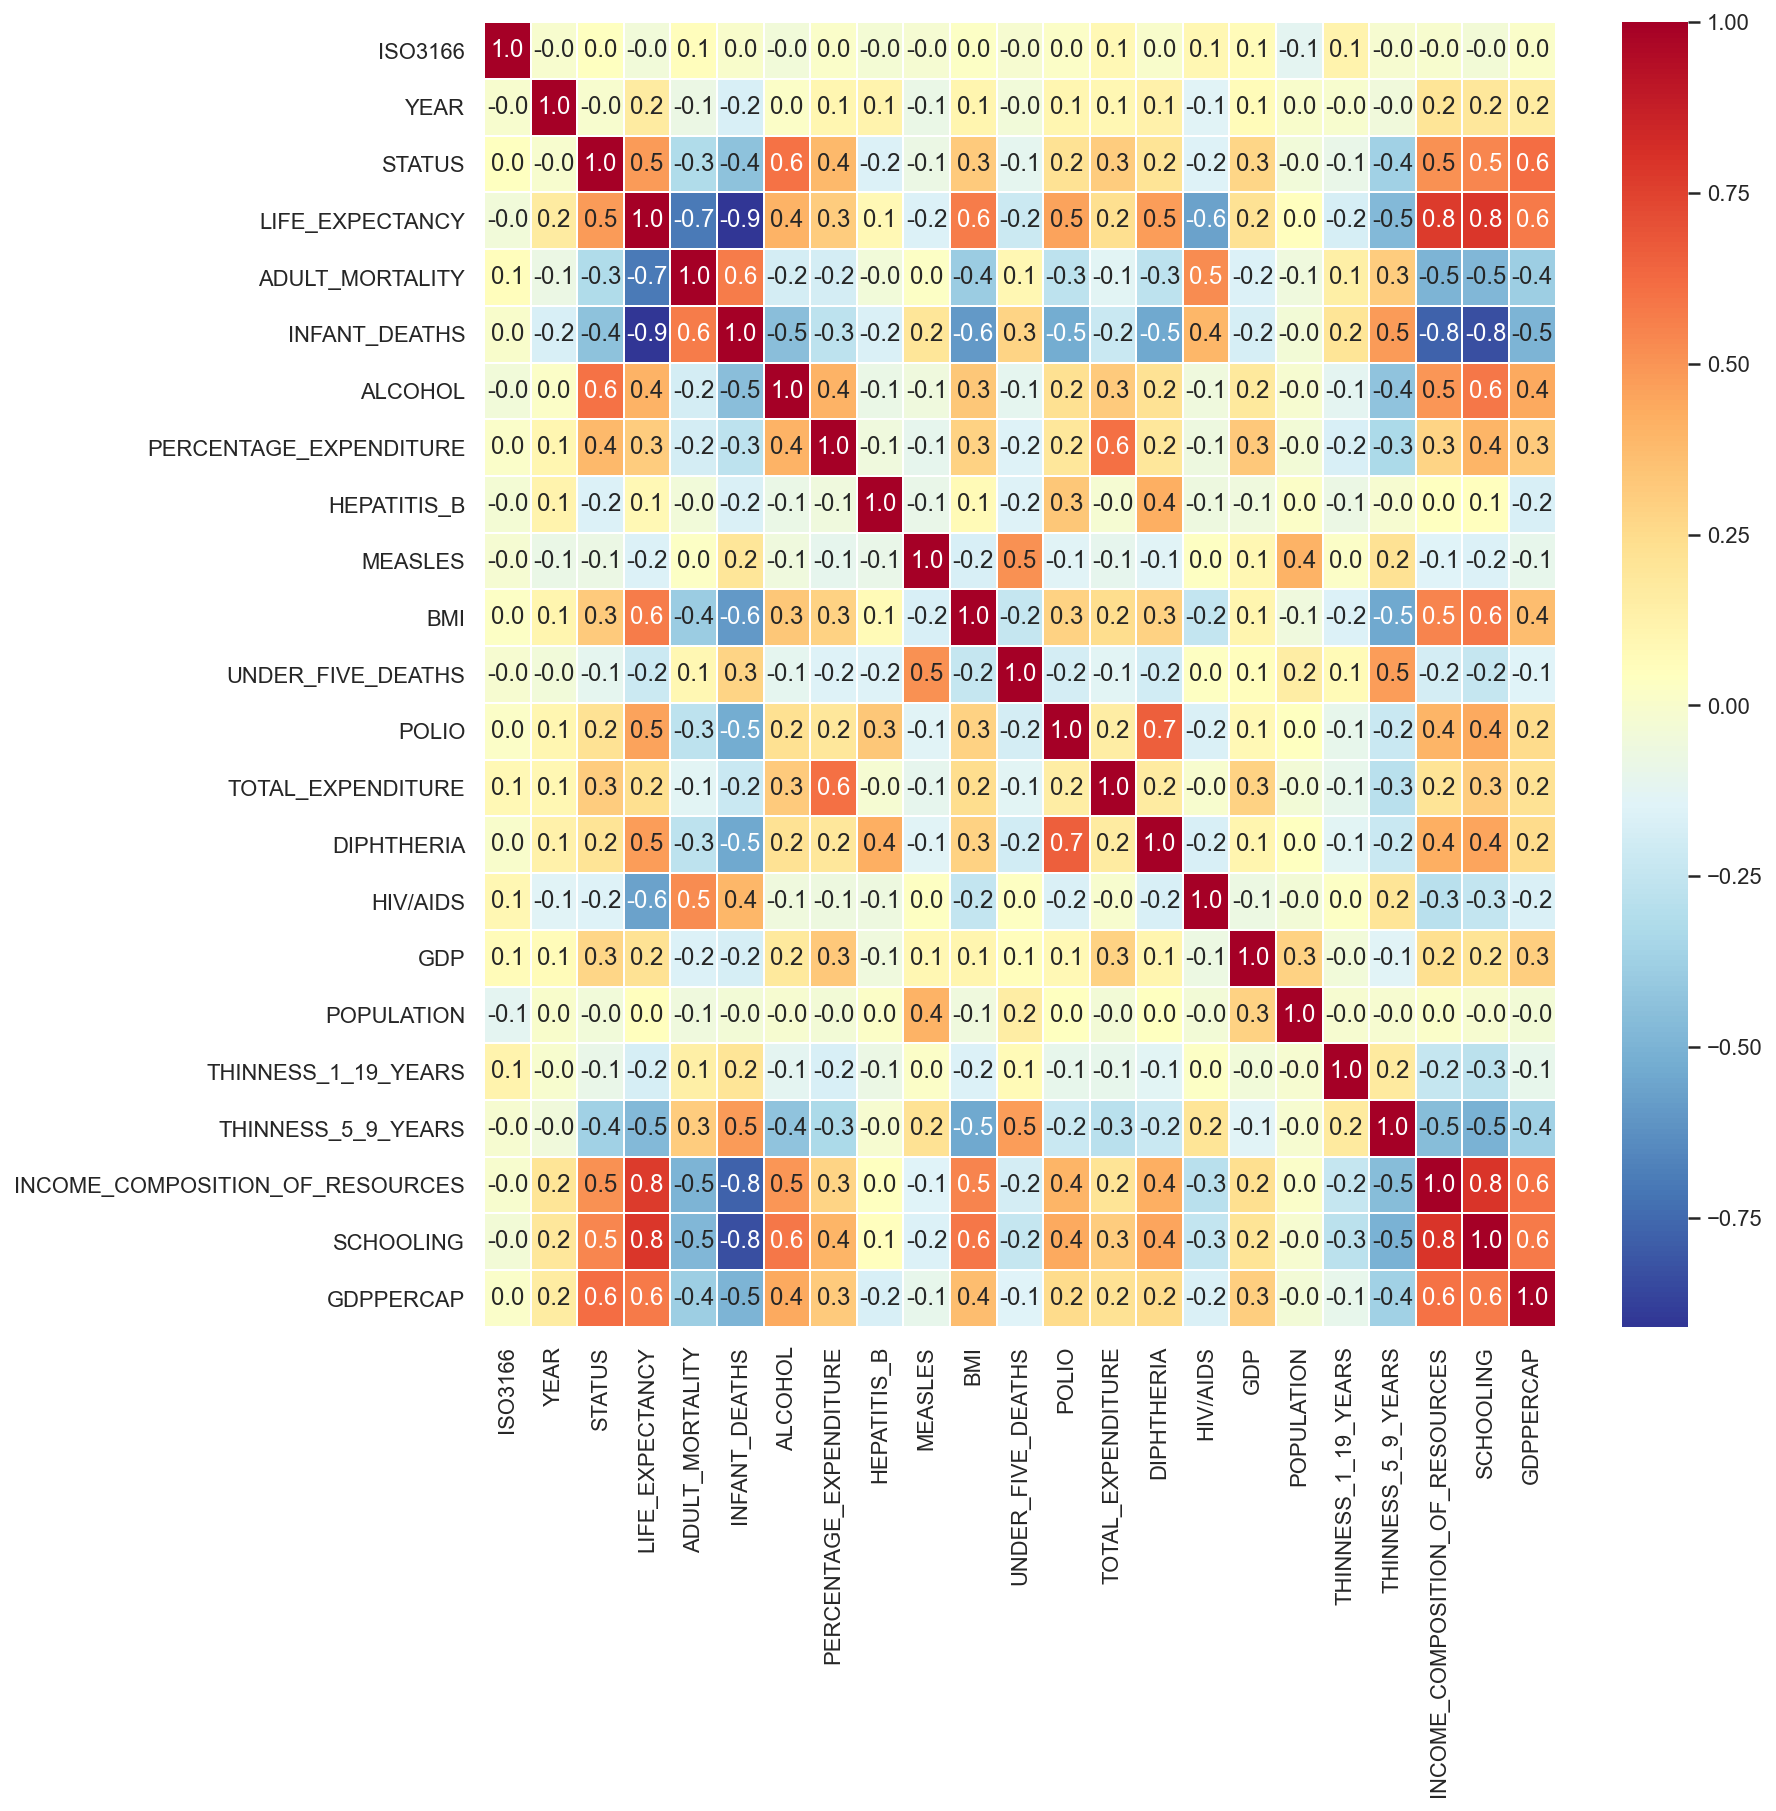

In [112]:
# Developing: 0, developed: 1
original["STATUS"] = [row.replace("Developing","0") for row in original["STATUS"].tolist()]
original["STATUS"] = [row.replace("Developed","1") for row in original["STATUS"].tolist()]
original["STATUS"] = [int(row) for row in original["STATUS"].tolist()]

plt.figure(figsize=(12,12))
sns.heatmap(original.corr(), annot=True, fmt='.1f', linewidths=0.5, cmap='RdYlBu_r');

- 각 컬럼별 연도에 따른 추이

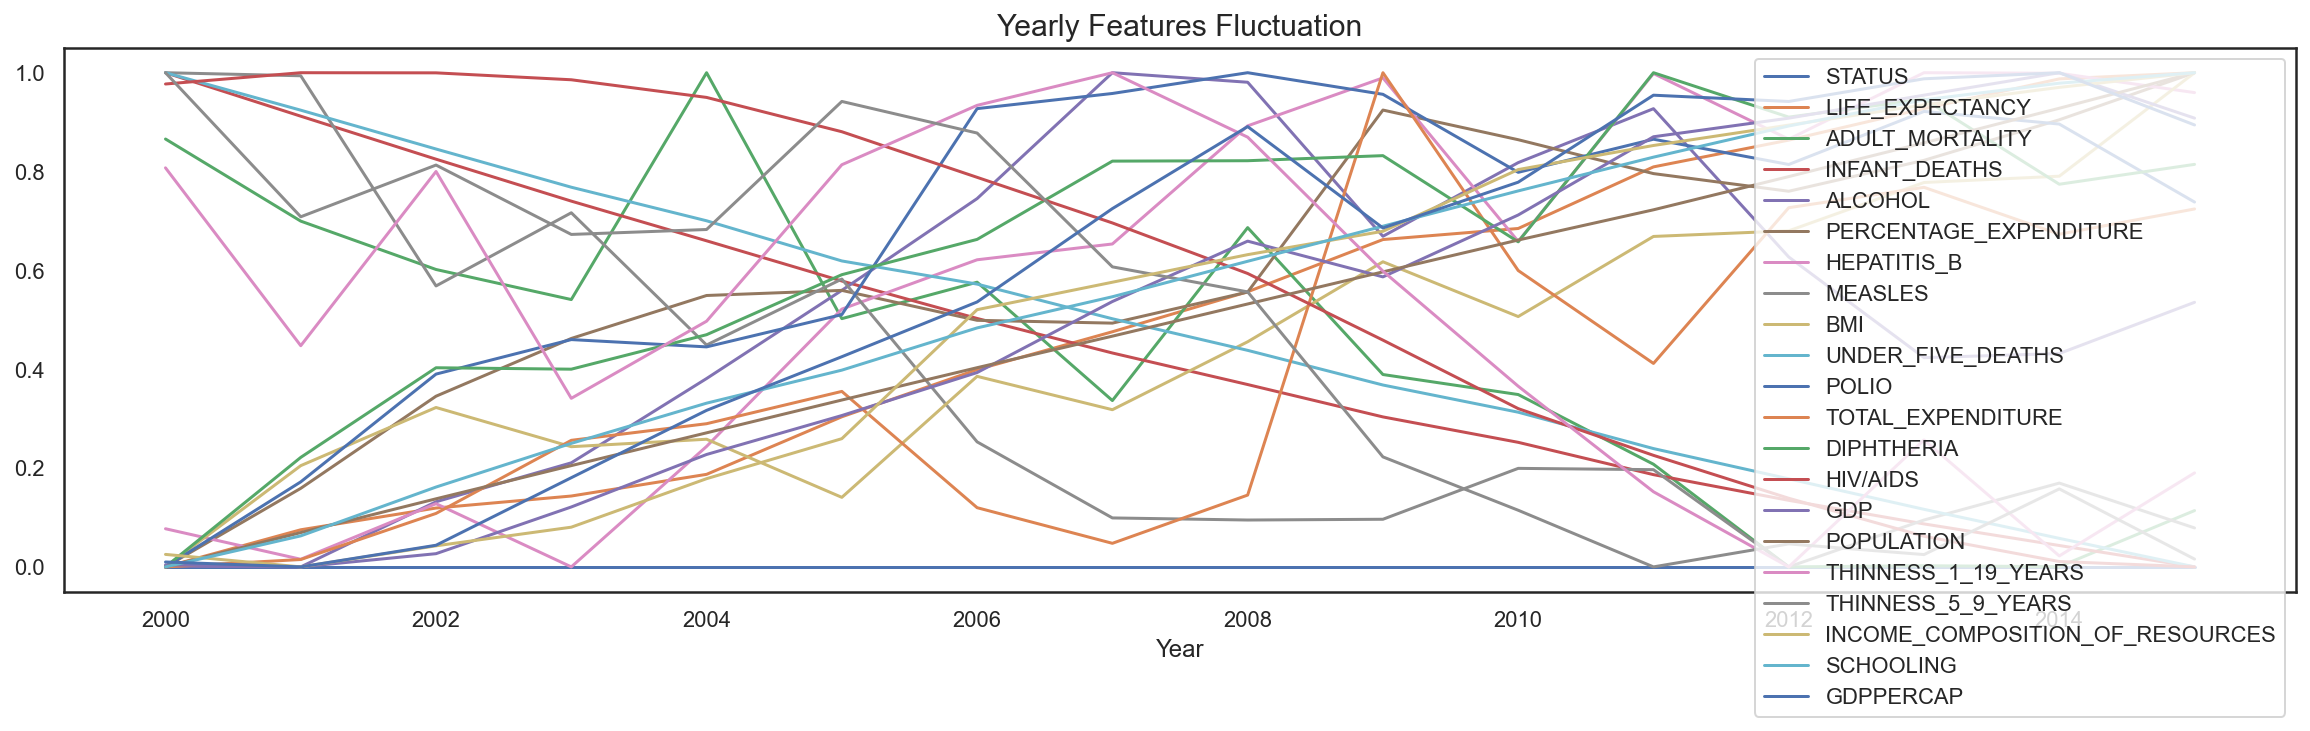

In [113]:
# 연도별로 groupby
year_data = original.groupby("YEAR").mean()
# ISO3166 컬럼 제외
year_data = year_data[year_data.columns.tolist()[1:]]

plt.figure(figsize=(20, 5))
plt.title("Yearly Features Fluctuation", fontsize= 15)
for a in year_data.columns.tolist():
    plt.plot(year_data.index, preprocessing.minmax_scale(year_data[a]), label=a)
    
plt.xlabel("Year")
plt.legend()
plt.show()

In [120]:
# mix-max scaling
scaled_year_data = pd.DataFrame(preprocessing.minmax_scale(year_data))
scaled_year_data.index = year_data.index
scaled_year_data.columns = year_data.columns.tolist()

# 대분류 카테고리로 컬럼 나누기
cat = {'economy': ['PERCENTAGE_EXPENDITURE', 'TOTAL_EXPENDITURE', 'GDP', 'POPULATION','INCOME_COMPOSITION_OF_RESOURCES'],
        'death_rate': ['INFANT_DEATHS', "ADULT_MORTALITY",'UNDER_FIVE_DEATHS'],
       'illness_rate': ['THINNESS_1_19_YEARS','THINNESS_5_9_YEARS', 'MEASLES', 'HIV/AIDS'],
        'vaccine': ['HEPATITIS_B','POLIO','DIPHTHERIA'],
        'others':['SCHOOLING','BMI', 'ALCOHOL']}

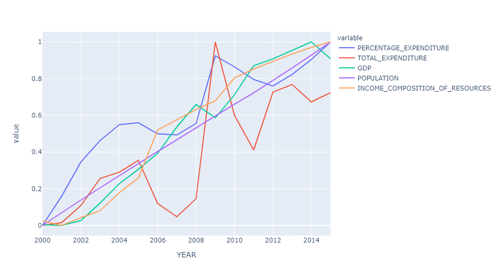

In [115]:
px.line(scaled_year_data[cat['economy']])

image= pil.open('../imgs/yearly_economy.png')
image.thumbnail((500, 700))
image

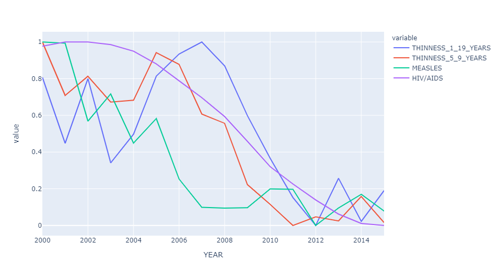

In [121]:
px.line(scaled_year_data[cat['death_rate']])

image= pil.open('../imgs/yearly_illness.png')
image.thumbnail((500, 700))
image

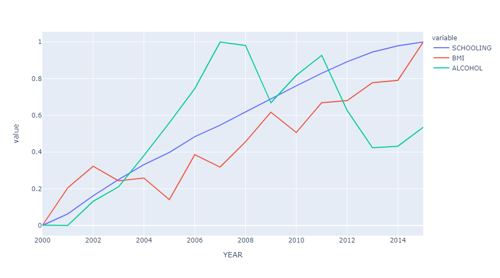

In [117]:
px.line(scaled_year_data[cat['vaccine']])

image= pil.open('../imgs/yearly_others.png')
image.thumbnail((500, 700))
image

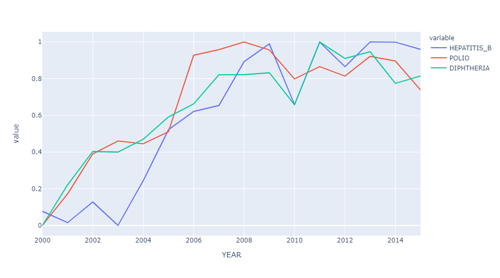

In [123]:
px.line(scaled_year_data[cat['vaccine']])

image= pil.open('../imgs/yearly_vaccine.png')
image.thumbnail((500, 700))
image

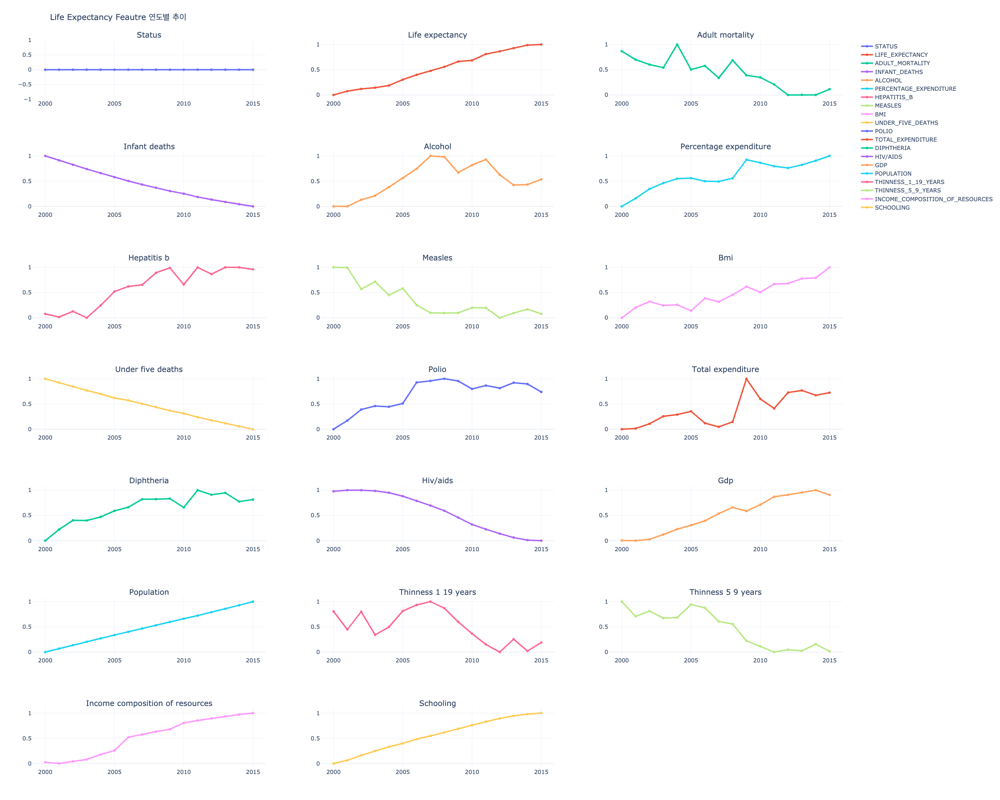

In [124]:
# raw data의 연도별 feature 추이
lower_titles = [scaled_year_data.columns.tolist()[i].lower().capitalize().replace('_', ' ') 
                for i in range(len(scaled_year_data.columns))]

fig = make_subplots(rows=7, cols=3, subplot_titles=lower_titles)
count = 0

for i in range(7):
    for j in range(3):
        if count == 19:
            break
           
        fig.add_trace(go.Scatter(x=scaled_year_data.index, 
                                 y=scaled_year_data[scaled_year_data.columns[count]], 
                                 name=scaled_year_data.columns[count],
                                 line=dict(width=3.5)), row=i+1, col=j+1)
        count += 1
        
fig.update_layout(title='Life Expectancy Feautre 연도별 추이', font_size=14,
                  width=2500, height=2000, template="plotly_white")
fig.update_annotations(font_size=18)
# fig.show()

image= pil.open('../imgs/subplots_country.png')
image.thumbnail((1000, 1200))
image

In [125]:
# region to Integer
region = {'South Asia': 0, 'Europe & Central Asia': 1, 
          'Middle East & North Africa': 2, 'Sub-Saharan Africa': 3,
          'Latin America & Caribbean': 4, 'East Asia & Pacific': 5, 'North America': 6}

original_df = original.drop(['COUNTRYCODE'], axis=1)
original_df = original_df.replace({'REGION': region})

# region별 dataframe 선언
regions_df = [pd.DataFrame(data=original_df[original_df['REGION'] == i]) for i in range(len(region))]

# region별 연도에 따라 groupby
year_merge_df = [regions_df[i].groupby('YEAR').mean().drop(['REGION', 'ISO3166'], axis=1)
                for i in range(len(region))]

# region별 feature 추이 
scaled_region_datas = [pd.DataFrame(data=preprocessing.minmax_scale(year_merge_df[i])) 
                       for i in range(len(region))]

for i in range(len(region)):
    scaled_region_datas[i].columns = year_merge_df[i].columns.tolist()
    scaled_region_datas[i].index = year_merge_df[i].index

scaled_region_datas[5].head(5)

,STATUS,LIFE_EXPECTANCY,ADULT_MORTALITY,INFANT_DEATHS,ALCOHOL,PERCENTAGE_EXPENDITURE,HEPATITIS_B,MEASLES,BMI,UNDER_FIVE_DEATHS,POLIO,TOTAL_EXPENDITURE,DIPHTHERIA,HIV/AIDS,GDP,POPULATION,THINNESS_1_19_YEARS,THINNESS_5_9_YEARS,INCOME_COMPOSITION_OF_RESOURCES,SCHOOLING,GDPPERCAP
YEAR,,,,,,,,,,,,,,,,,,,,,
2000,0.0,0.000000,0.955143,1.000000,0.254989,0.000000,0.000000,0.975886,0.394770,1.000000,0.255422,0.089643,0.000000,0.90625,0.039501,0.000000,1.000000,1.000000,0.124633,1.776357e-15,0.054707
2001,0.0,0.105941,1.000000,0.904284,0.215078,0.260673,0.490608,1.000000,0.591532,0.897744,0.532530,0.342217,0.214932,1.00000,0.000000,0.083585,0.975758,0.968127,0.000000,0.000000e+00,0.000000
2002,0.0,0.192079,0.507347,0.810910,0.096822,0.410621,0.395580,0.779889,0.430137,0.798496,0.400000,0.443973,0.104072,1.00000,0.009262,0.161199,0.942424,0.932271,0.037520,9.270217e-02,0.025777
2003,0.0,0.354455,0.529776,0.723896,0.101996,0.416175,0.422099,0.623659,0.000000,0.700752,0.542169,0.561781,0.208145,0.93750,0.065007,0.234006,0.639394,0.876494,0.083850,2.209073e-01,0.112289
2004,0.0,0.373267,0.847641,0.647256,0.000000,0.572024,0.053039,0.597300,0.399502,0.657143,0.351807,0.000000,0.262443,0.90625,0.138150,0.303836,0.609091,0.470120,0.130506,3.570020e-01,0.232029


In [126]:
cat_region_df, regions_df = [], []

for i in range(len(year_merge_df)):

    economy_df = year_merge_df[i][cat['economy']]
    death_df = year_merge_df[i][cat['death_rate']]
    illness_df = year_merge_df[i][cat['illness_rate']]
    vaccine_df = year_merge_df[i][cat['vaccine']]
    others_df = year_merge_df[i][cat['others']]
    
    regions_df.append(economy_df)
    regions_df.append(death_df)
    regions_df.append(illness_df)
    regions_df.append(vaccine_df)
    regions_df.append(others_df)
    
    cat_region_df.append(regions_df)
    regions_df = []

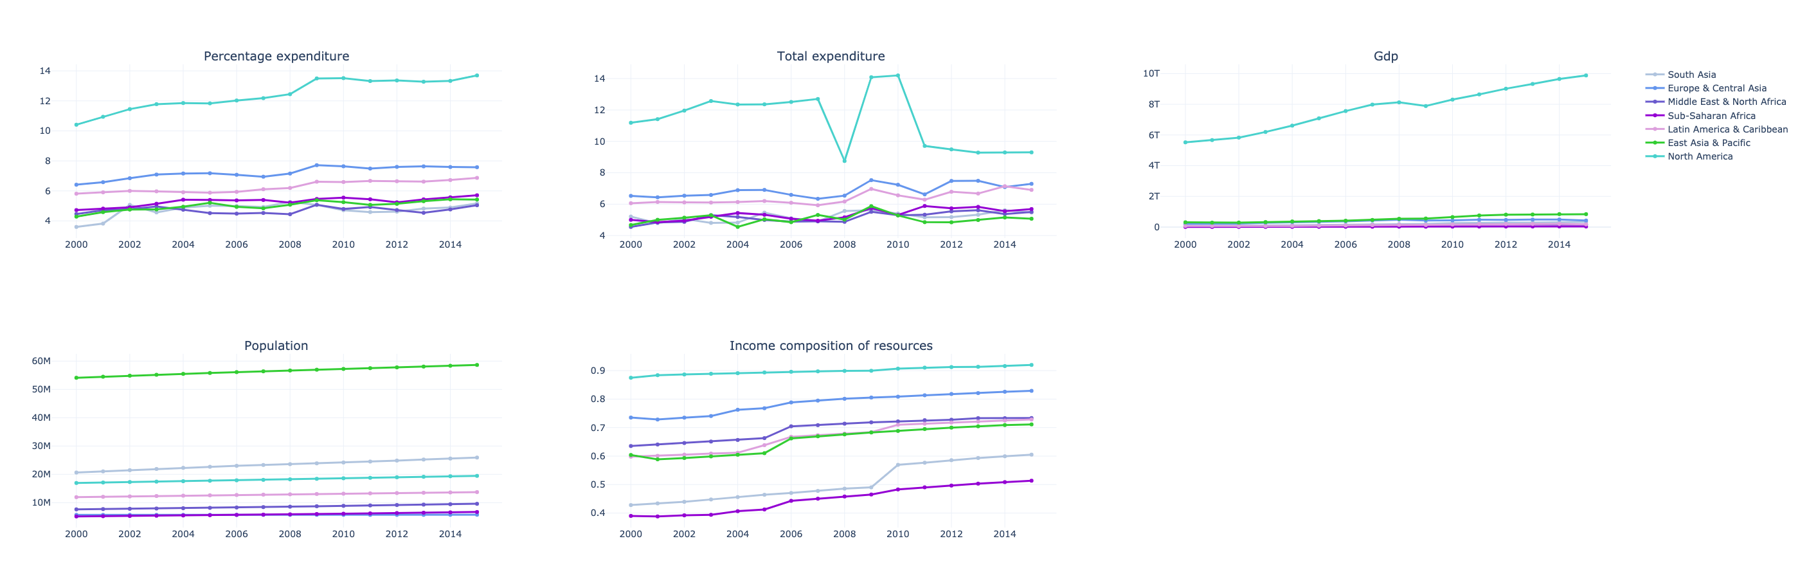

In [127]:
# 경제
economy = []

for i in range(len(region)):
    economy.append(cat_region_df[i][0])
    
lower_titles = [economy[0].columns.tolist()[i].lower().capitalize().replace('_', ' ') 
                for i in range(len(economy[0].columns))]

fig = make_subplots(rows=2, cols=3, subplot_titles=lower_titles)
count = 0
colors = ['lightsteelblue', 'cornflowerblue', 'slateblue', 'darkviolet', 'plum', 'limegreen', 'mediumturquoise']

for i in range(2):
    for j in range(3):
        if count == len(economy[0].columns):
            break
            
        for k in range(len(region)):
            flag = True if count == 0 else False
            fig.add_trace(go.Scatter(x=economy[0].index, 
                                     y=economy[k][economy[k].columns[count]], 
                                     name=list(region.items())[k][0],
                                     showlegend=flag, 
                                     marker=dict(color=colors[k]), line=dict(width=3)), row=i+1, col=j+1)
            
        count += 1
        
fig.update_layout(font_size=14,
                  width=2800, height=900, template="plotly_white")
fig.update_annotations(font_size=19)

# fig.show()
image= pil.open('../imgs/region_economy.png')
image.thumbnail((1800, 1400))
image

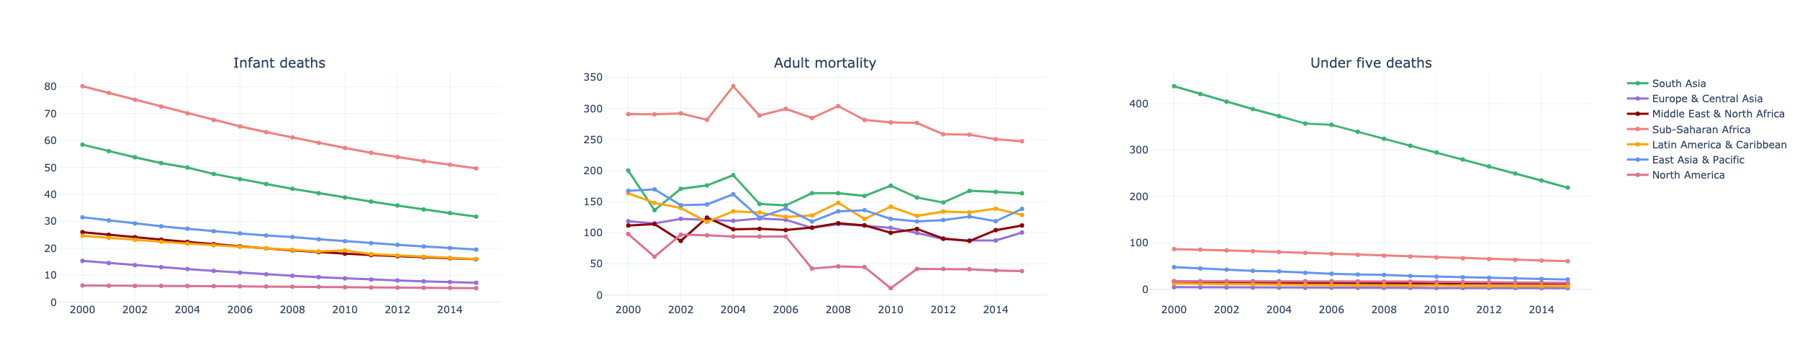

In [128]:
# 사망률
death_rate = []

for i in range(len(region)):
    death_rate.append(cat_region_df[i][1])

lower_titles = [death_rate[0].columns.tolist()[i].lower().capitalize().replace('_', ' ') 
                for i in range(len(death_rate[0].columns))]

fig = make_subplots(rows=1, cols=3, subplot_titles=lower_titles)
count = 0
colors = ['mediumseagreen', 'mediumpurple', 'darkRed', 'lightcoral', 'orange', 'cornflowerblue', 'palevioletred']

for i in range(1):
    for j in range(3):
        if count == len(death_rate[0].columns):
            break
            
        for k in range(len(region)):
            flag = True if count == 0 else False
            fig.add_trace(go.Scatter(x=death_rate[0].index, 
                                     y=death_rate[k][death_rate[k].columns[count]], 
                                     name=list(region.items())[k][0],
                                     showlegend=flag, 
                                     marker=dict(color=colors[k]), line=dict(width=3)), row=i+1, col=j+1)
            
        count += 1
        
fig.update_layout(font_size=14,
                  width=2500, height=500, template="plotly_white")
fig.update_annotations(font_size=19)

# fig.show()
image= pil.open('../imgs/region_death.png')
image.thumbnail((1800, 1400))
image

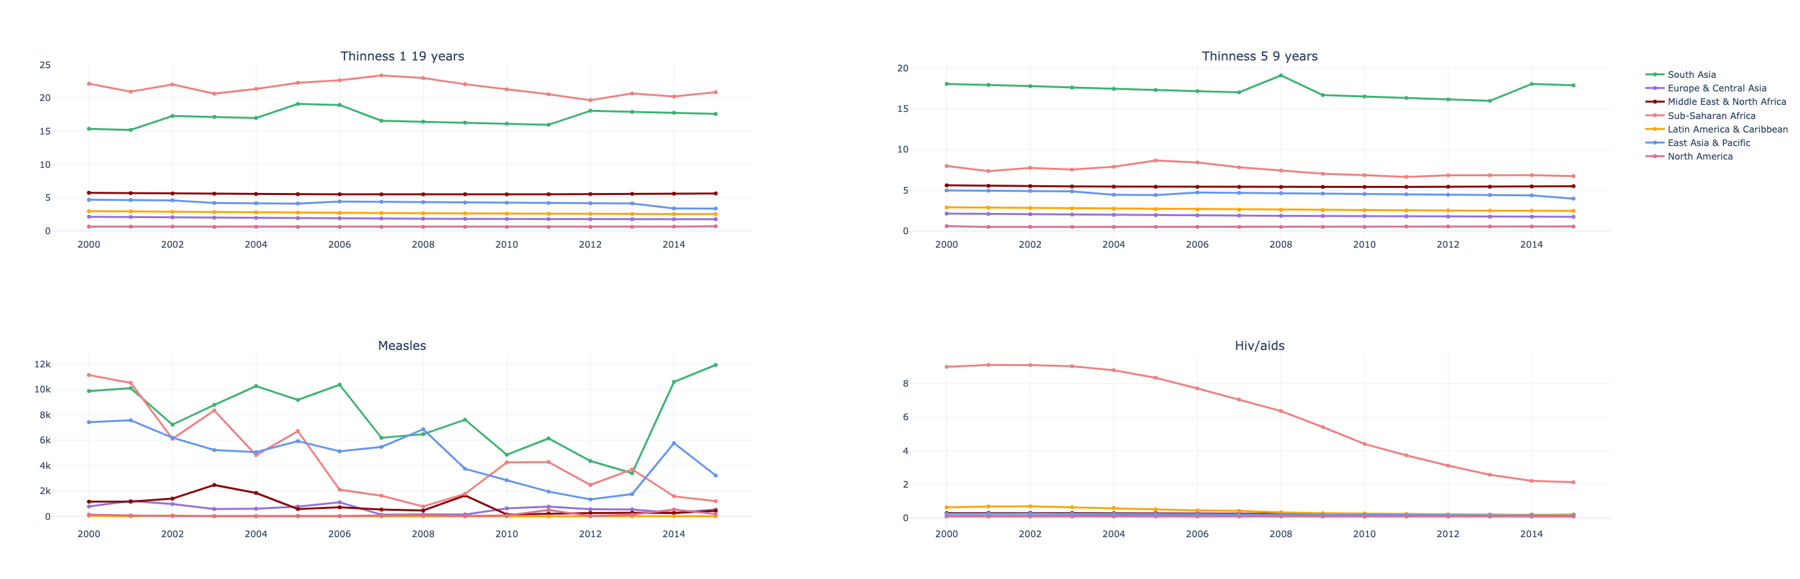

In [129]:
# 유병률
illness_rate = []

for i in range(len(region)):
    illness_rate.append(cat_region_df[i][2])

lower_titles = [illness_rate[0].columns.tolist()[i].lower().capitalize().replace('_', ' ') 
                for i in range(len(illness_rate[0].columns))]

fig = make_subplots(rows=2, cols=2, subplot_titles=lower_titles)
count = 0
colors = ['mediumseagreen', 'mediumpurple', 'darkRed', 'lightcoral', 'orange', 'cornflowerblue', 'palevioletred']

for i in range(2):
    for j in range(2):
        if count == len(illness_rate[0].columns):
            breakbb
            
        for k in range(len(region)):
            flag = True if count == 0 else False
            fig.add_trace(go.Scatter(x=illness_rate[0].index, 
                                     y=illness_rate[k][illness_rate[k].columns[count]], 
                                     name=list(region.items())[k][0],
                                     showlegend=flag, 
                                     marker=dict(color=colors[k]), line=dict(width=3)), row=i+1, col=j+1)
            
        count += 1
        
fig.update_layout(font_size=14,
                  width=2500, height=1000, template="plotly_white")
fig.update_annotations(font_size=19)

# fig.show()
image= pil.open('../imgs/region_illness.png')
image.thumbnail((1800, 1400))
image

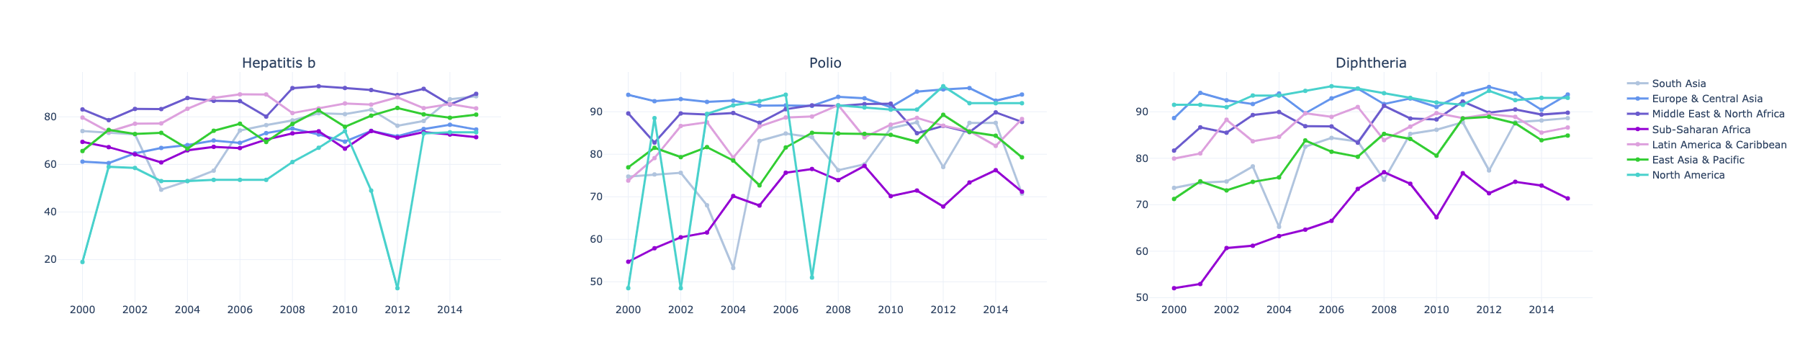

In [130]:
# 백신
vaccine = []

for i in range(len(region)):
    vaccine.append(cat_region_df[i][3])

lower_titles = [vaccine[0].columns.tolist()[i].lower().capitalize().replace('_', ' ') 
                for i in range(len(vaccine[0].columns))]

fig = make_subplots(rows=1, cols=3, subplot_titles=lower_titles)
count = 0
colors = ['lightsteelblue', 'cornflowerblue', 'slateblue', 'darkviolet', 'plum', 'limegreen', 'mediumturquoise']

for i in range(1):
    for j in range(3):
        if count == len(illness_rate[0].columns):
            break
            
        for k in range(len(region)):
            flag = True if count == 0 else False
            fig.add_trace(go.Scatter(x=vaccine[0].index, 
                                     y=vaccine[k][vaccine[k].columns[count]], 
                                     name=list(region.items())[k][0],
                                     showlegend=flag, 
                                     marker=dict(color=colors[k]), line=dict(width=3)), row=i+1, col=j+1)
            
        count += 1
        
fig.update_layout(font_size=14,
                  width=2500, height=500, template="plotly_white")
fig.update_annotations(font_size=19)

# fig.show()
image= pil.open('../imgs/region_vaccine.png')
image.thumbnail((1800, 1400))
image

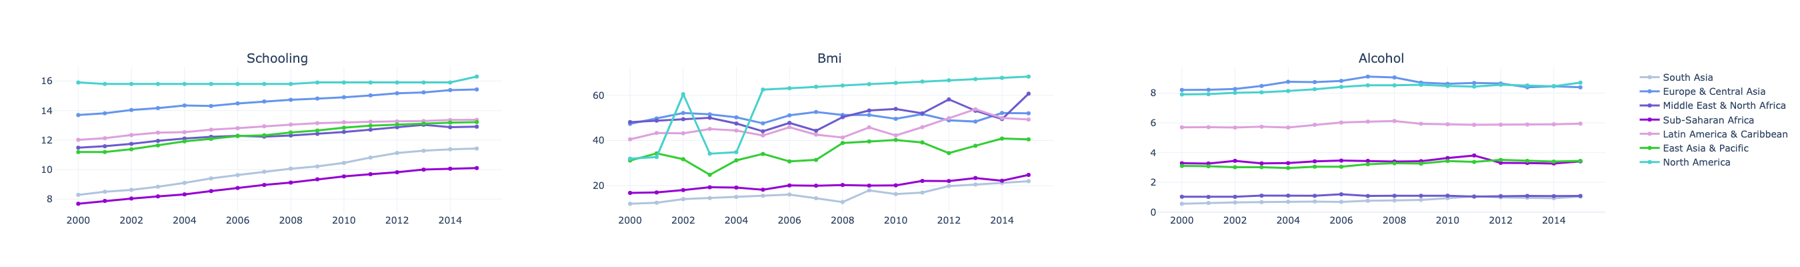

In [131]:
# 기타
others = []

for i in range(len(region)):
    others.append(cat_region_df[i][4])

lower_titles = [others[0].columns.tolist()[i].lower().capitalize().replace('_', ' ') 
                for i in range(len(others[0].columns))]

fig = make_subplots(rows=1, cols=3, subplot_titles=lower_titles)
count = 0
colors = ['lightsteelblue', 'cornflowerblue', 'slateblue', 'darkviolet', 'plum', 'limegreen', 'mediumturquoise']

for i in range(1):
    for j in range(3):
        if count == len(others[0].columns):
            break
            
        for k in range(len(region)):
            flag = True if count == 0 else False
            fig.add_trace(go.Scatter(x=others[0].index, 
                                     y=others[k][others[k].columns[count]], 
                                     name=list(region.items())[k][0],
                                     showlegend=flag, 
                                     marker=dict(color=colors[k]), line=dict(width=3)), row=i+1, col=j+1)
            
        count += 1
        
fig.update_layout(font_size=14,
                  width=2700, height=400, template="plotly_white")
fig.update_annotations(font_size=19)

# fig.show()
image= pil.open('../imgs/region_others.png')
image.thumbnail((1800, 1200))
image

In [132]:
original = pd.read_csv(PATH + 'life_expectancy_data_fillna.csv')
original.columns = [cols.upper() for cols in original.columns.tolist()]

# Developing: 0, developed: 1
original["STATUS"] = [row.replace("Developing","0") for row in original["STATUS"].tolist()]
original["STATUS"] = [row.replace("Developed","1") for row in original["STATUS"].tolist()]
original["STATUS"] = [int(row) for row in original["STATUS"].tolist()]

mean_df = original.groupby(['COUNTRY']).mean().round(3).drop(['YEAR'], axis=1)
mean_df

,ISO3166,STATUS,LIFE_EXPECTANCY,ADULT_MORTALITY,INFANT_DEATHS,ALCOHOL,PERCENTAGE_EXPENDITURE,HEPATITIS_B,MEASLES,BMI,UNDER_FIVE_DEATHS,POLIO,TOTAL_EXPENDITURE,DIPHTHERIA,HIV/AIDS,GDP,POPULATION,THINNESS_1_19_YEARS,THINNESS_5_9_YEARS,INCOME_COMPOSITION_OF_RESOURCES,SCHOOLING
COUNTRY,,,,,,,,,,,,,,,,,,,,,
Afghanistan,4.0,0.0,58.194,269.062,70.875,0.014,8.264,64.562,2362.250,15.519,107.562,48.375,8.252,52.312,0.100,1.134344e+10,2.745116e+07,16.581,15.581,0.415,8.212
Albania,8.0,0.0,75.156,45.062,15.250,4.849,5.870,98.000,53.375,49.069,0.938,98.125,5.946,98.062,0.100,9.476655e+09,2.968698e+06,1.619,1.700,0.710,12.137
Algeria,12.0,0.0,73.619,108.188,26.750,0.449,4.634,78.000,1943.875,48.744,23.500,91.750,4.766,91.875,0.100,1.339053e+11,3.482137e+07,6.094,5.975,0.695,12.712
Angola,24.0,0.0,49.019,328.562,88.613,5.901,3.027,70.125,3561.312,18.019,132.625,46.125,3.911,47.688,2.369,6.943623e+10,2.162286e+07,6.194,6.669,0.458,8.044
Antigua and Barbuda,28.0,0.0,75.056,127.500,9.875,8.004,5.097,98.250,0.000,38.425,0.000,96.938,4.829,98.312,0.125,1.097706e+09,8.480194e+04,3.425,3.375,0.489,14.169
Argentina,32.0,0.0,75.156,106.000,13.850,7.954,8.636,81.250,2.000,54.981,11.375,93.375,6.787,92.375,0.100,3.457328e+11,3.991411e+07,1.075,0.950,0.794,16.506
Armenia,51.0,0.0,73.400,117.375,19.200,3.714,7.523,87.562,274.250,44.706,1.000,89.125,4.839,87.375,0.100,7.306080e+09,2.950902e+06,2.038,2.113,0.698,11.787
Australia,36.0,1.0,81.812,63.188,4.306,10.118,8.303,93.375,103.938,55.862,1.375,86.750,8.872,86.875,0.100,9.397500e+11,2.128915e+07,0.669,0.625,0.918,20.037
Austria,40.0,1.0,81.481,65.750,3.812,12.233,9.828,81.062,77.250,48.288,0.000,86.000,5.121,86.750,0.100,3.454375e+11,8.296244e+06,1.731,1.938,0.862,15.388


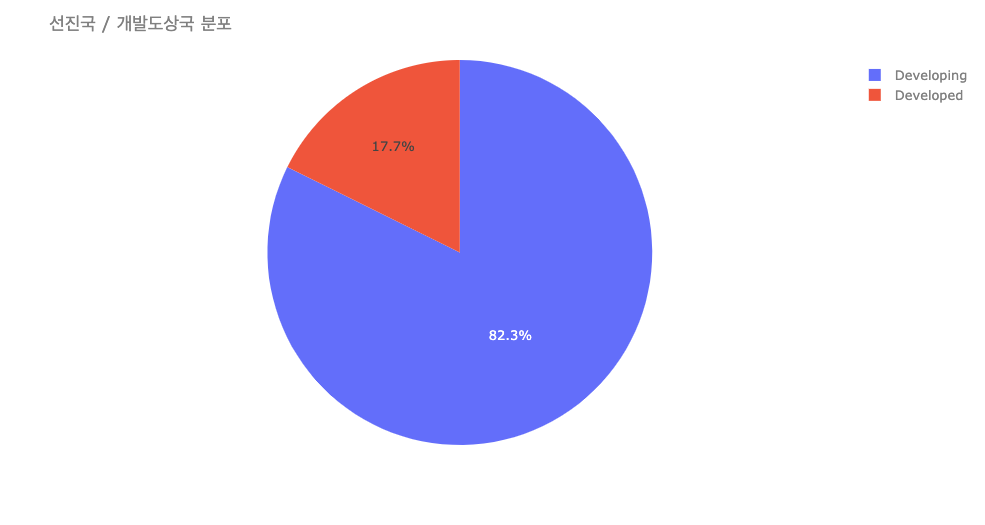

In [133]:
# developed / developing 분포
status_df = original.groupby(['STATUS']).count()

fig = px.pie(status_df, values='COUNTRY', names=['Developing', 'Developed'])
fig.update_layout(title='선진국 / 개발도상국 분포', font_color="grey", font=dict(size=13))
# fig.show()

image= pil.open('../imgs/pie_develop.png')
image.thumbnail((1200, 1000))
image

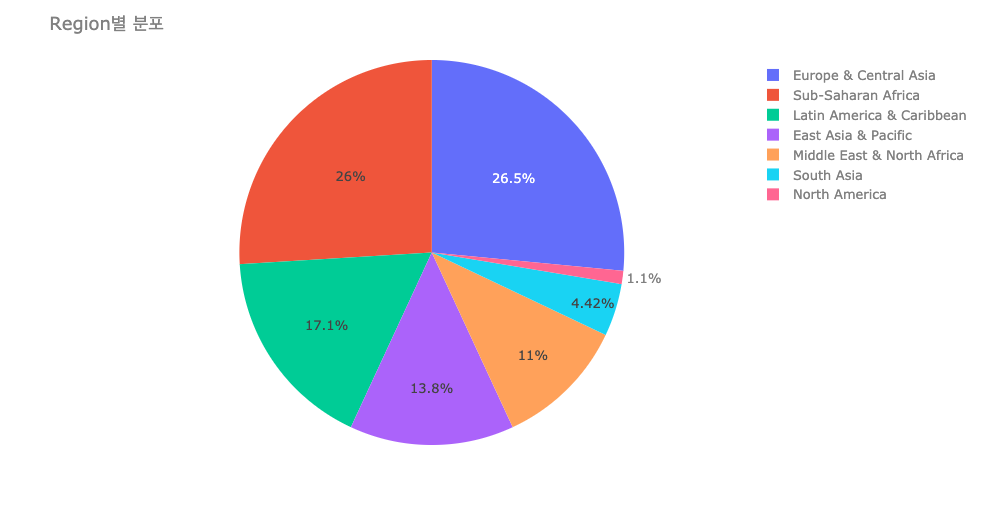

In [134]:
# region 분포
region_df = original.groupby(['REGION']).count()

fig = px.pie(region_df, values='COUNTRY', names=region_df.index.tolist())
fig.update_layout(title='Region별 분포', font_color="grey", font=dict(size=13))
# fig.show()

image= pil.open('../imgs/pie_region.png')
image.thumbnail((1200, 1000))
image

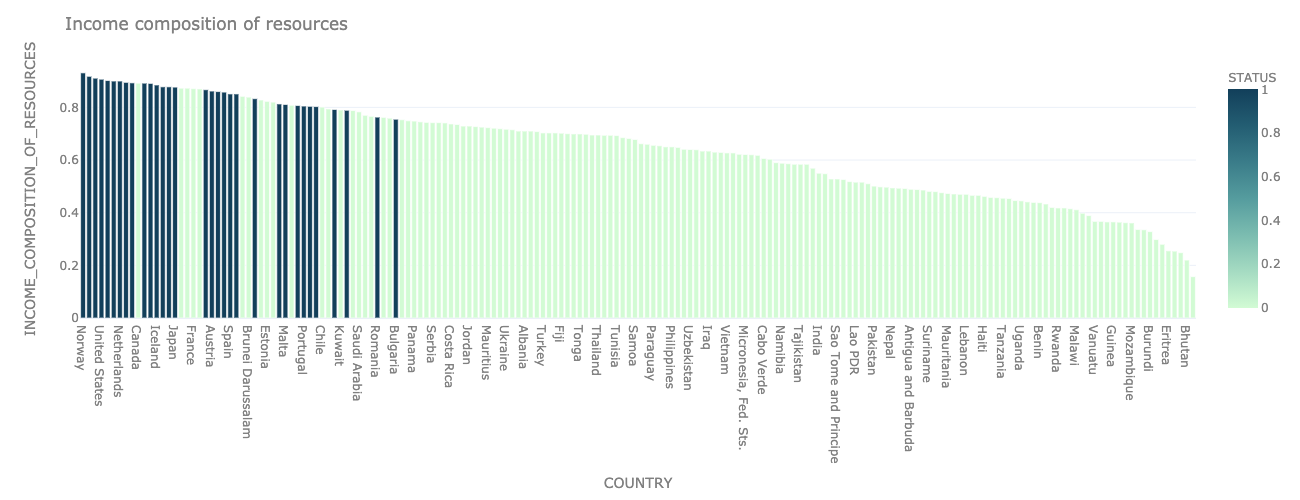

In [135]:
# 상관관계가 높은 feature 선진국 / 개발도상국에 따른 나라별 구분
cols = ['LIFE_EXPECTANCY', 'INCOME_COMPOSITION_OF_RESOURCES', 'SCHOOLING', 'HIV/AIDS', 'INFANT_DEATHS', 'ADULT_MORTALITY']
lower_cols = [col.lower().capitalize().replace('_', ' ') for col in cols]
colors = ['Burg', 'Darkmint', 'Purp', 'Redor', 'Teal', 'Magenta']

for i in range(5):
    hdi_df = mean_df.sort_values(by=cols[i], ascending=False)

    fig = px.bar(hdi_df, x=hdi_df.index, y=hdi_df[cols[i]], color=hdi_df['STATUS'],
                barmode='group', color_continuous_scale=colors[i])

    fig.update_layout(
        title_text=lower_cols[i],
        height=500,
        width=1000,
        template='plotly_white',
        font_color='grey'
    )
    
# fig.show()

image= pil.open('../imgs/hdi.png')
image.thumbnail((1800, 1400))
image

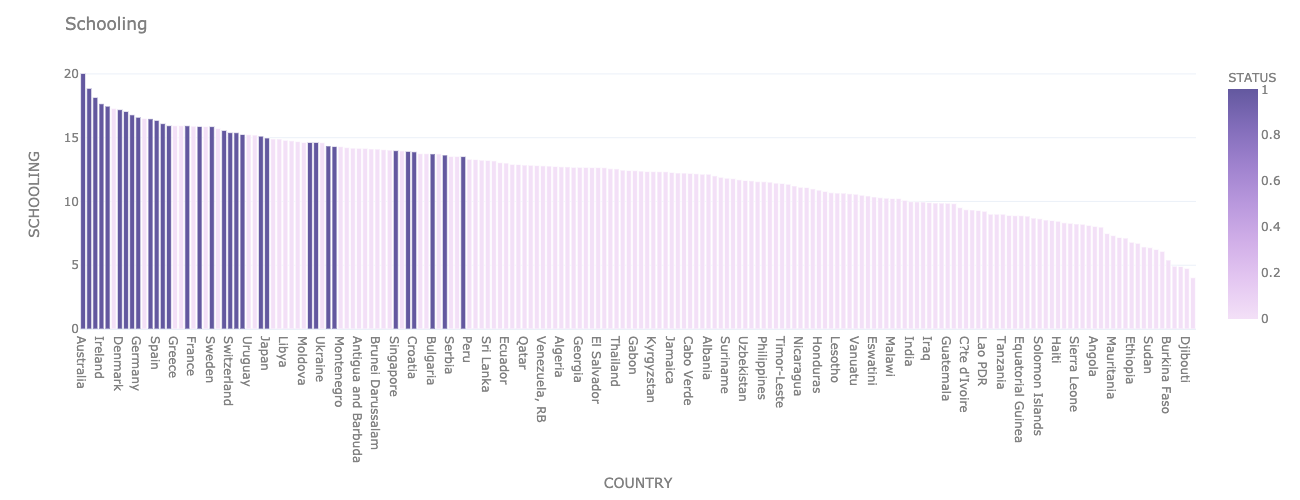

In [80]:
image= pil.open('../imgs/schooling.png')
image.thumbnail((1800, 1400))
image

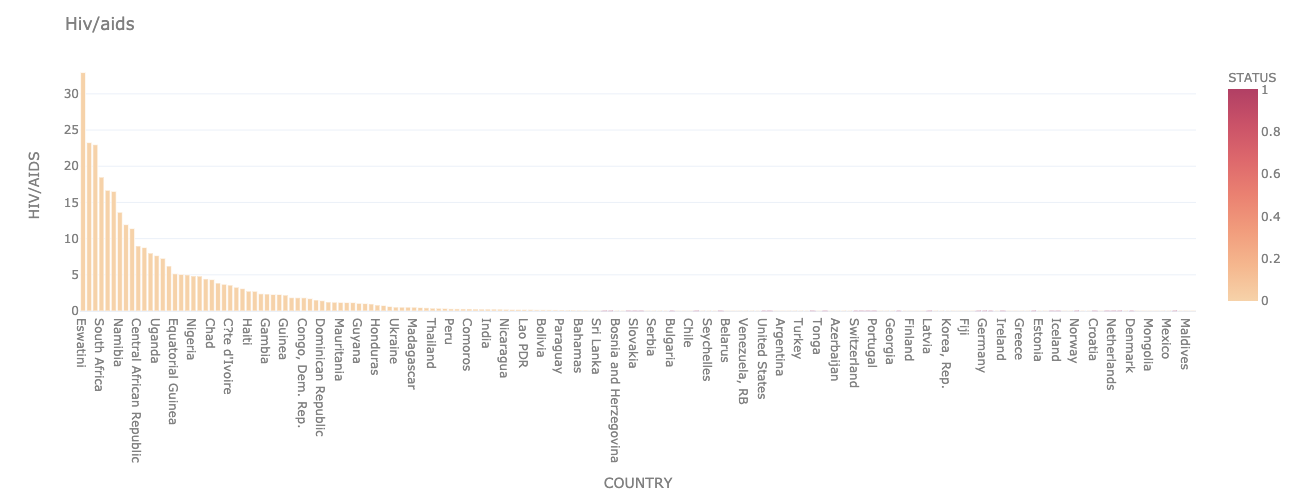

In [81]:
image= pil.open('../imgs/hiv.png')
image.thumbnail((1800, 1400))
image

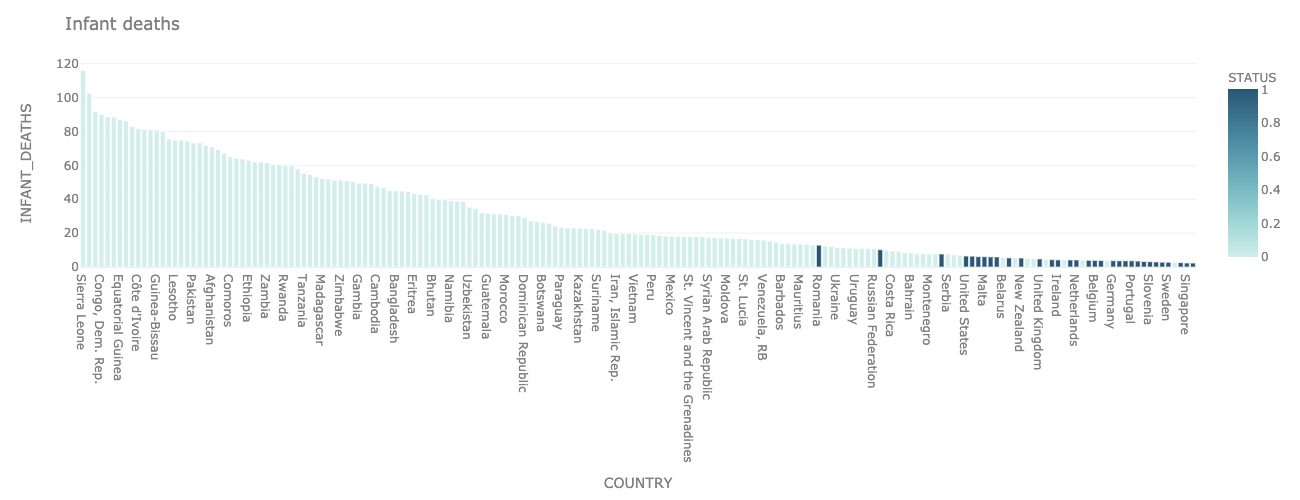

In [83]:
image= pil.open('../imgs/infant_deaths.png')
image.thumbnail((1800, 1400))
image

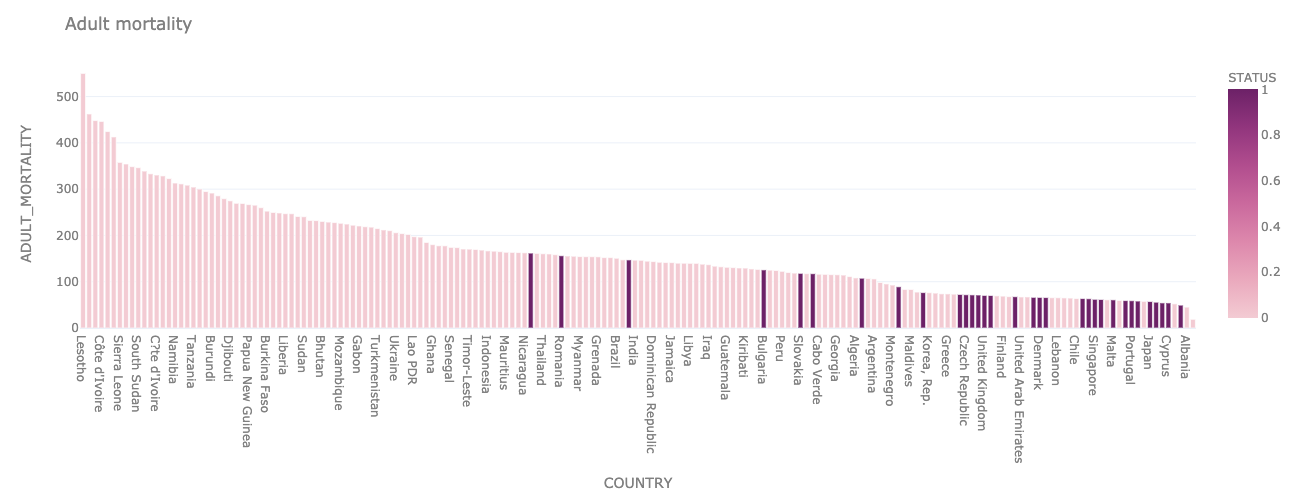

In [84]:
image= pil.open('../imgs/adult_mortality.png')
image.thumbnail((1800, 1400))
image

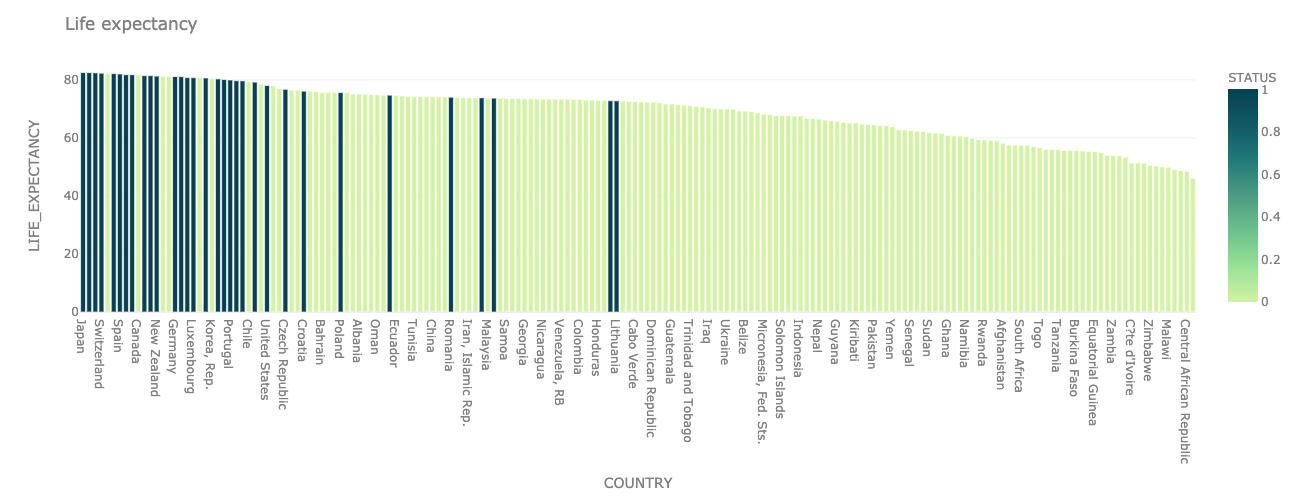

In [85]:
image= pil.open('../imgs/life_expectancy.png')
image.thumbnail((1800, 1400))
image

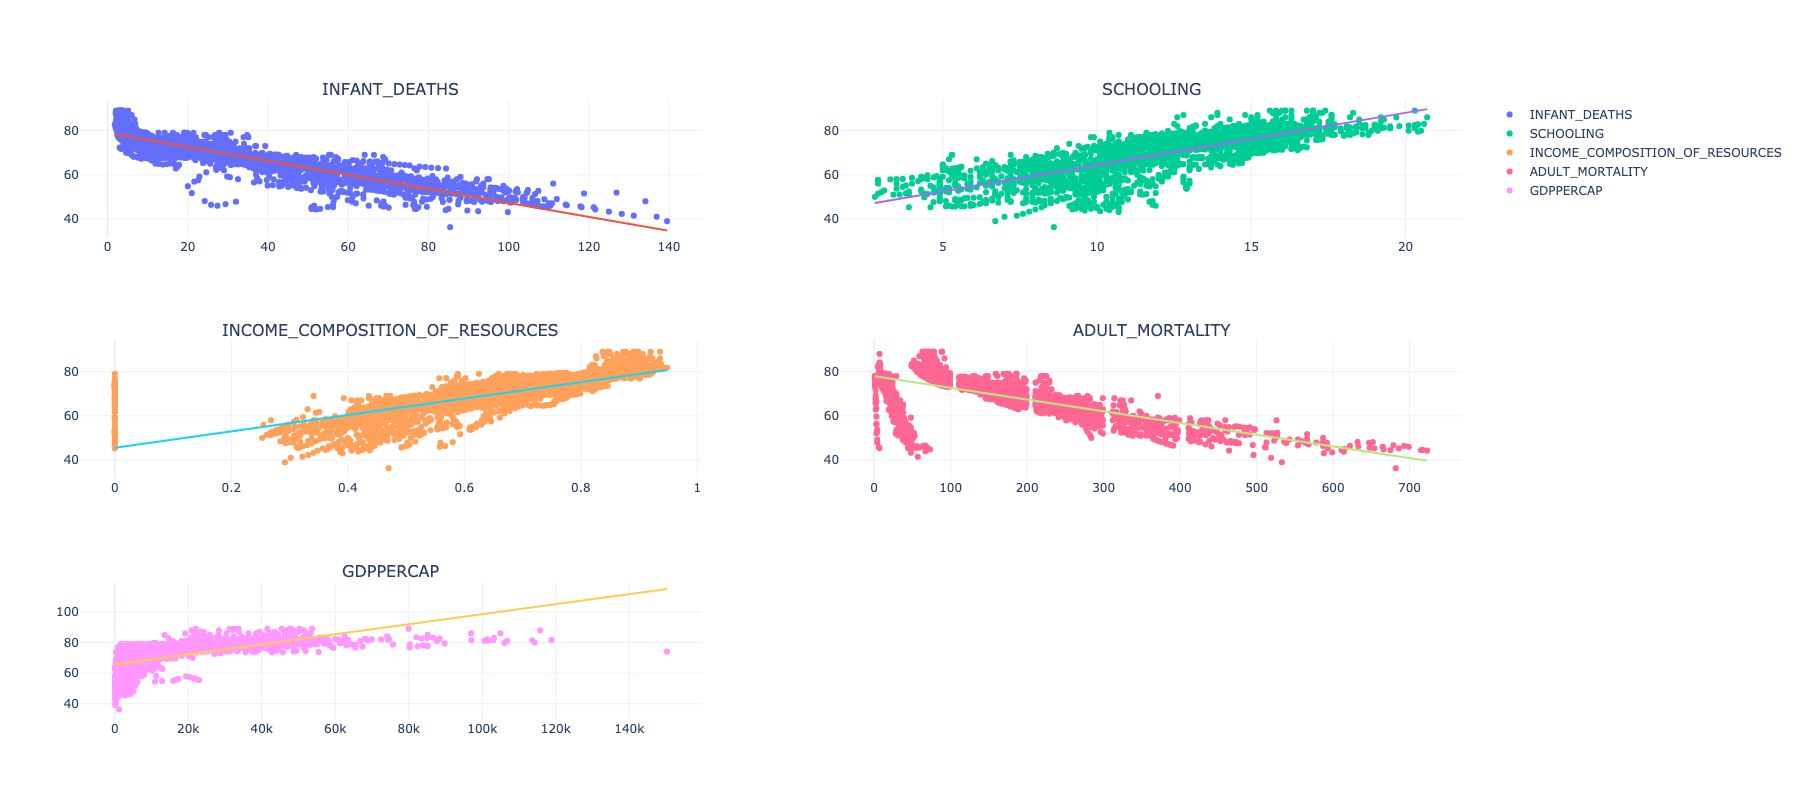

In [155]:
# 주요 feature regression plot
top_features = top_features[1:]
target = original['LIFE_EXPECTANCY']

fig = make_subplots(rows=3, cols=2, subplot_titles=top_features)
count = 0

for i in range(3):
    for j in range(2):
        if count >= len(top_features):
            break
            
        regline = sm.OLS(target, sm.add_constant(original[top_features[count]])).fit().fittedvalues

        fig.add_traces(go.Scatter(x=original[top_features[count]], 
                                  y=target, mode='markers', name=top_features[count]),
                               rows=i+1, cols=j+1)

        fig.add_traces(go.Scatter(x=original[top_features[count]], 
                                  y=regline, mode='lines',
                                  showlegend=False), 
                       rows=i+1, cols=j+1)

        count += 1
        
fig.update_layout(width=1800, height=800, template='plotly_white')

# fig.show()
image= pil.open('../imgs/regression_plot.png')
image.thumbnail((1800, 2000))
image